In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Preprocessing

In [2]:
# importing Dataset
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-06-15 03:46:46--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  57.2MB/s    in 3.0s    

2020-06-15 03:46:50 (57.2 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2020-06-15 03:46:57--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  52.0MB/s    in 1.2s    

2020-06-15 03:46:58 (52.0 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [0]:
from scipy.io import loadmat
train = loadmat("/content/train_32x32.mat")
test = loadmat("/content/test_32x32.mat")

In [4]:
x_train = train['X']
y_train = train['y']
x_test = test['X']
y_test = test['y']
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)
(73257, 1)
(26032, 1)


In [5]:
x_train = np.moveaxis(x_train, -1, 0)
x_test = np.moveaxis(x_test, -1, 0)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)
(73257, 1)
(26032, 1)


In [6]:
print(np.max(y_train))
print(np.min(y_train))

10
1


In [7]:
y_train[y_train==10]=0;
y_test[y_test==10]=0;
print(np.max(y_train))
print(np.min(y_train))

9
0


In [0]:
def plot_random_images(images, labels):
  random_idx = np.random.randint(0,images.shape[0], 25)
  random_images = images[random_idx]
  random_labels = labels[random_idx]

  plt.figure(figsize=(10, 10))

  for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(random_images[i])
    plt.xlabel(f"{random_labels[i]}")
  plt.show()


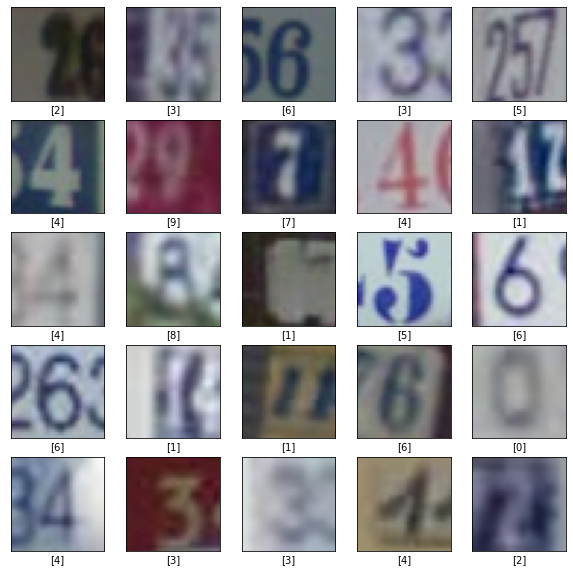

In [9]:
plot_random_images(x_train, y_train)

In [0]:
x_train = np.mean(x_train, -1)
x_test = np.mean(x_test, -1)

In [11]:
print(x_train.shape)
print(x_test.shape)

(73257, 32, 32)
(26032, 32, 32)


In [0]:
# we add newaxis only for convolutional purpose 
# to plot the image we have to remove the squeeze the newaxis
x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]

In [13]:
print(x_train.shape)
print(x_test.shape)

(73257, 32, 32, 1)
(26032, 32, 32, 1)


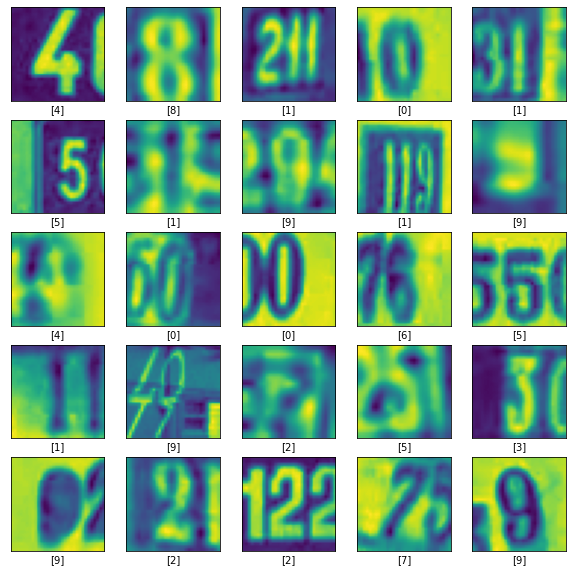

In [14]:
plot_random_images(np.squeeze(x_train, -1), y_train)

# Simple Model 

In [0]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [0]:
def model(input_shape):
    model = Sequential([
                        Flatten(input_shape = input_shape, name='flatten'),
                        Dense(128, activation='relu', name='dense1'),
                        Dense(64, activation='relu', name='dense2'),
                        Dense(64, activation='relu', name='dense3'),
                        Dense(32, activation='relu', name='dense4'),
                        Dense(10, activation='softmax', name='dense5')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy'])
    return model

In [36]:
my_model = model(x_train[0].shape)
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               131200    
_________________________________________________________________
dense2 (Dense)               (None, 64)                8256      
_________________________________________________________________
dense3 (Dense)               (None, 64)                4160      
_________________________________________________________________
dense4 (Dense)               (None, 32)                2080      
_________________________________________________________________
dense5 (Dense)               (None, 10)                330       
Total params: 146,026
Trainable params: 146,026
Non-trainable params: 0
________________________________________________

In [0]:
callback1 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, min_delta=0.001, Patience = 5, cooldown = 5)

callback2 = ModelCheckpoint(filepath = "best_checkpoint", monitor = 'val_loss', save_best_only = True, save_weights_only = False)

In [38]:
history = my_model.fit(x_train, y_train, validation_split = 0.1, epochs = 30, batch_size = 128, callbacks=[callback1, callback2])

Epoch 1/30
516/516 [==============================] - 2s 5ms/step - loss: 3.5759 - sparse_categorical_accuracy: 0.1674 - sparse_top_k_categorical_accuracy: 0.6084 - val_loss: 2.6123 - val_sparse_categorical_accuracy: 0.1668 - val_sparse_top_k_categorical_accuracy: 0.6854 - lr: 0.0010
Epoch 2/30
516/516 [==============================] - 2s 4ms/step - loss: 1.8568 - sparse_categorical_accuracy: 0.3800 - sparse_top_k_categorical_accuracy: 0.7977 - val_loss: 1.9373 - val_sparse_categorical_accuracy: 0.3357 - val_sparse_top_k_categorical_accuracy: 0.8131 - lr: 0.0010
Epoch 3/30
516/516 [==============================] - 2s 4ms/step - loss: 1.5548 - sparse_categorical_accuracy: 0.4906 - sparse_top_k_categorical_accuracy: 0.8621 - val_loss: 1.5537 - val_sparse_categorical_accuracy: 0.5019 - val_sparse_top_k_categorical_accuracy: 0.8615 - lr: 0.0010
Epoch 4/30
516/516 [==============================] - 2s 4ms/step - loss: 1.4262 - sparse_categorical_accuracy: 0.5487 - sparse_top_k_categorical

In [39]:
#history object has history dictionary
df = pd.DataFrame(history.history)
df.head()

,loss,sparse_categorical_accuracy,sparse_top_k_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,val_sparse_top_k_categorical_accuracy,lr
0,3.575886,0.167448,0.608424,2.612283,0.166803,0.685367,0.001
1,1.856807,0.379973,0.797698,1.937254,0.335654,0.813131,0.001
2,1.554786,0.490589,0.862129,1.553668,0.501911,0.861452,0.001
3,1.426173,0.548725,0.879601,1.467281,0.530713,0.877969,0.001
4,1.357940,0.574146,0.885593,1.242298,0.606607,0.902539,0.001


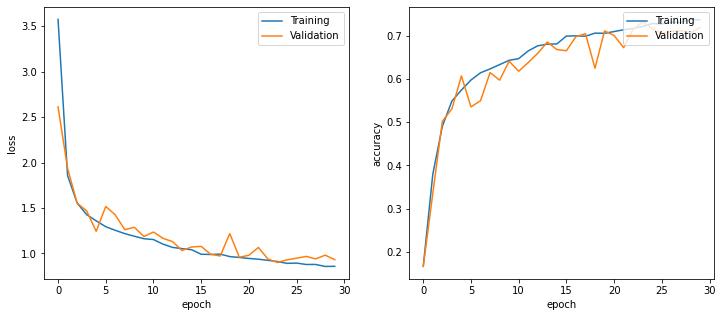

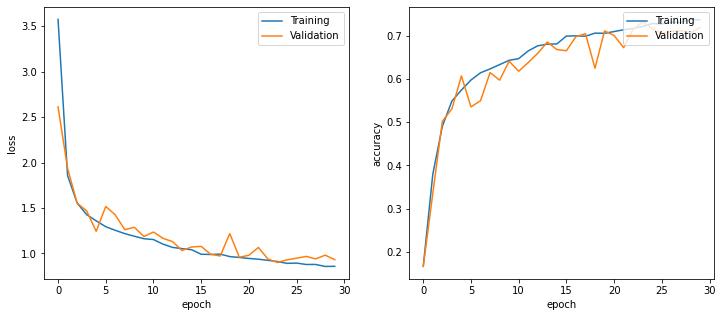

In [40]:
# My intuition about this way of plotting figure is first create a fig space and then pick up the subplots and plot into them 
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(df['loss'])
plt.plot(df['val_loss'])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(['Training', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(df['sparse_categorical_accuracy'])
plt.plot(df['val_sparse_categorical_accuracy'])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(['Training', 'Validation'], loc='upper right')


# another way to plot
# My intuition about this way of plotting figure is first declare a figure and then add up the subplots and plot into them 
fig = plt.figure(figsize = (12, 5))

fig.add_subplot(121)
plt.plot(df['loss'])
plt.plot(df['val_loss'])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)
plt.plot(df['sparse_categorical_accuracy'])
plt.plot(df['val_sparse_categorical_accuracy'])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(['Training', 'Validation'], loc='upper right')

In [41]:
my_model.evaluate(x_test, y_test, verbose =2)

814/814 - 2s - loss: 1.0645 - sparse_categorical_accuracy: 0.6939 - sparse_top_k_categorical_accuracy: 0.9284


[1.0645263195037842, 0.6939151883125305, 0.9283958077430725]

# CNN Model

In [0]:
from tensorflow.keras.layers import BatchNormalization, Dropout

In [0]:
# In MaxPool2D if you don't specify the stride then it will be equal to the pool size
def cnn_model(input_shape):
  model = Sequential([
                      Conv2D(16, 3, input_shape = input_shape, padding = 'same', activation = 'relu', name="conv_1"),
                      BatchNormalization(name="BN1"),
                      Dropout(0.3),
                      MaxPool2D(3, name="Pool_1"),
                      Conv2D(32, 3, padding = 'same', activation = 'relu', name="conv_2"),
                      BatchNormalization(name="BN2"),
                      Dropout(0.3),
                      MaxPool2D(2, name="Pool_2"),
                      Flatten(name = "flatten"),
                      Dense(32, activation='relu', name='dense1'),
                      Dense(10, activation='softmax', name ='dense2')
  ])
  model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy'])
  return model

In [75]:
my_cnn_model = cnn_model(x_train[0].shape)
my_cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
BN1 (BatchNormalization)     (None, 32, 32, 16)        64        
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 10, 10, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 10, 10, 32)        4640      
_________________________________________________________________
BN2 (BatchNormalization)     (None, 10, 10, 32)        128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 10, 32)       

In [0]:
callback1 = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, cooldown =5, factor = 0.1, min_delta = 0.001)

callback2 = ModelCheckpoint(filepath = 'cnn_best_checkpoint', monitor='val_loss', save_best_only=True, save_weights_only= False)

In [77]:
cnn_history=my_cnn_model.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size = 128, callbacks = [callback1, callback2])

Epoch 1/10
516/516 [==============================] - 4s 7ms/step - loss: 1.2075 - sparse_categorical_accuracy: 0.6032 - sparse_top_k_categorical_accuracy: 0.8997 - val_loss: 0.7706 - val_sparse_categorical_accuracy: 0.7538 - val_sparse_top_k_categorical_accuracy: 0.9626 - lr: 0.0010
Epoch 2/10
516/516 [==============================] - 4s 7ms/step - loss: 0.6543 - sparse_categorical_accuracy: 0.8009 - sparse_top_k_categorical_accuracy: 0.9713 - val_loss: 0.7030 - val_sparse_categorical_accuracy: 0.7778 - val_sparse_top_k_categorical_accuracy: 0.9655 - lr: 0.0010
Epoch 3/10
516/516 [==============================] - 4s 7ms/step - loss: 0.5619 - sparse_categorical_accuracy: 0.8278 - sparse_top_k_categorical_accuracy: 0.9767 - val_loss: 0.5432 - val_sparse_categorical_accuracy: 0.8344 - val_sparse_top_k_categorical_accuracy: 0.9772 - lr: 0.0010
Epoch 4/10
516/516 [==============================] - 2s 5ms/step - loss: 0.5129 - sparse_categorical_accuracy: 0.8444 - sparse_top_k_categorical

In [78]:
df = pd.DataFrame(cnn_history.history)
df.head()

,loss,sparse_categorical_accuracy,sparse_top_k_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,val_sparse_top_k_categorical_accuracy,lr
0,1.207475,0.603206,0.899728,0.770583,0.753754,0.962599,0.001
1,0.654310,0.800913,0.971303,0.702966,0.777778,0.965465,0.001
2,0.561947,0.827820,0.976733,0.543194,0.834425,0.977205,0.001
3,0.512943,0.844428,0.978447,0.561871,0.833060,0.978570,0.001
4,0.483135,0.852285,0.980965,0.570383,0.831968,0.978296,0.001


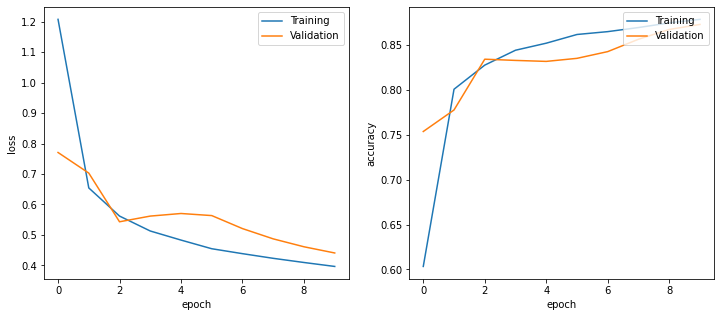

In [79]:
fig = plt.figure(figsize = (12, 5))

fig.add_subplot(121)
plt.plot(df['loss'])
plt.plot(df['val_loss'])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Training", "Validation"], loc = 'upper right')

fig.add_subplot(122)
plt.plot(df['sparse_categorical_accuracy'])
plt.plot(df['val_sparse_categorical_accuracy'])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["Training", "Validation"], loc = 'upper right')


In [80]:
my_cnn_model.evaluate(x_test, y_test, verbose =2)

814/814 - 2s - loss: 0.4665 - sparse_categorical_accuracy: 0.8707 - sparse_top_k_categorical_accuracy: 0.9831


[0.46650856733322144, 0.8706591725349426, 0.983059287071228]

# Getting Model Prediction

In [0]:
from tensorflow.keras.models import load_model

In [0]:
model_mlp = load_model("/content/best_checkpoint")
model_cnn = load_model("/content/cnn_best_checkpoint")

In [83]:
model_mlp.evaluate(x_test, y_test, verbose=2)
model_cnn.evaluate(x_test, y_test, verbose=2)

814/814 - 2s - loss: 1.0746 - sparse_categorical_accuracy: 0.6900 - sparse_top_k_categorical_accuracy: 0.9259
814/814 - 2s - loss: 0.4665 - sparse_categorical_accuracy: 0.8707 - sparse_top_k_categorical_accuracy: 0.9831


[0.46650856733322144, 0.8706591725349426, 0.983059287071228]

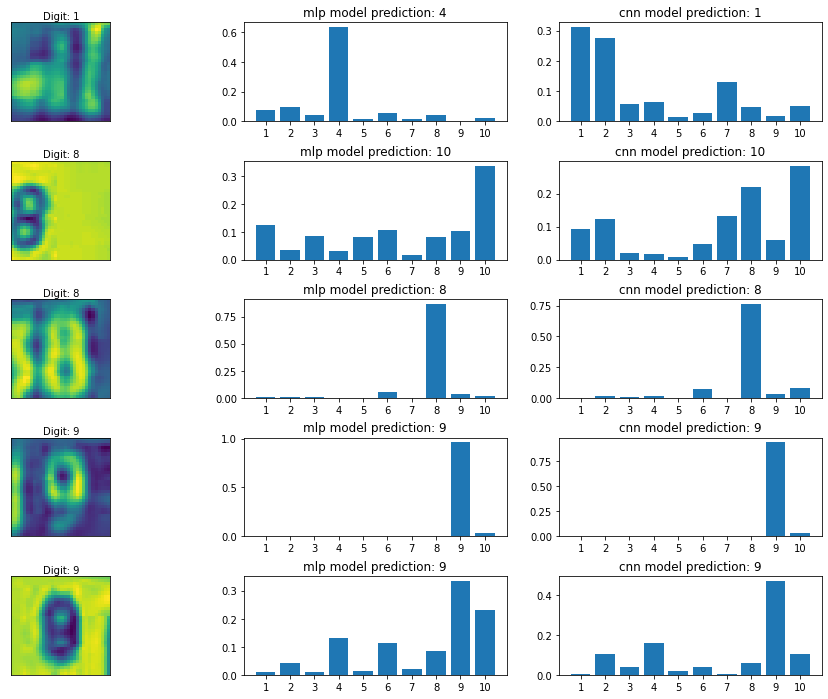

In [99]:
random_idx = np.random.randint(0, x_test.shape[0], size = 5)
random_images =x_test[random_idx]
random_labels =y_test[random_idx]
random_labels[random_labels==0]=10

prediction_mlp = model_mlp.predict(random_images)
prediction_cnn = model_cnn.predict(random_images)

# appending zeroth column from start to last because it predicts 10
prediction_mlp = np.concatenate((prediction_mlp[:, 1:], prediction_mlp[:, 0, np.newaxis]), axis= 1)
prediction_cnn = np.concatenate((prediction_cnn[:, 1:], prediction_cnn[:, 0, np.newaxis]), axis= 1)


# another way of plotting the figures
# note that plt.subplot is different from plt.subplots
fig, axes = plt.subplots(5,3, figsize=(16,12))
fig.subplots_adjust(hspace = 0.4, wspace = 0.2)

for i, (pred_mlp, pred_cnn, img, label) in enumerate(zip(prediction_mlp, prediction_cnn, random_images, random_labels)):
  axes[i,0].imshow(np.squeeze(img))
  axes[i,0].get_xaxis().set_visible(False)
  axes[i,0].get_yaxis().set_visible(False)
  axes[i,0].text(10., -1.5, f"Digit: {np.squeeze(label)}")
  
  # one way to draw a bar chart
  axes[i,1].bar(np.arange(len(pred_mlp)), pred_mlp, tick_label = np.arange(1, len(pred_mlp)+1))
  axes[i,1].set_title(f"mlp model prediction: {np.argmax(pred_mlp)+1}")
  axes[i,1].set_xticks(np.arange(len(pred_mlp)))
  
  # other way to draw a bar chart
  axes[i,2].bar(np.arange(1, len(pred_cnn)+1), pred_cnn)
  axes[i,2].set_title(f"cnn model prediction: {np.argmax(pred_cnn)+1}")
  axes[i,2].set_xticks(np.arange(1, len(pred_cnn)+1))

plt.show()